In [8]:
# This notebook is used to decide on a tolerable level of corruptableness.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import entropy as KL_divergence

from lda_cython.topic_models import SLDA
from modules.helpers import plot_images

In [11]:
# Generate topics
# We assume a vocabulary of 'rows'^2 terms, and create 'rows'*2 "topics",
# where each topic assigns exactly 'rows' consecutive terms equal probability.
rows = 3
V = rows * rows
K = rows * 2
N = K * K
D = 10000
seed = 42
topics = []
topic_base = np.concatenate((np.ones((1, rows)) * (1/rows),
                             np.zeros((rows-1, rows))), axis=0).ravel()
for i in range(rows):
     topics.append(np.roll(topic_base, i * rows))
topic_base = np.concatenate((np.ones((rows, 1)) * (1/rows),
                             np.zeros((rows, rows-1))), axis=1).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)

# Generate documents from topics
# We generate D documents from these V topics by sampling D topic
# distributions, one for each document, from a Dirichlet distribution with
# parameter α=(1,…,1)
alpha = np.ones(K)
np.random.seed(seed)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=N, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1,
                                               p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V,
                                         range=(0, V - 1))[0] for d in range(D)])

# Generate responses
# Choose prameter values
nu2 = K
sigma2 = 1
np.random.seed(seed)
eta = np.random.normal(scale=nu2, size=K)
y = [np.dot(eta, thetas[i]) for i in range(D)] + np.random.normal(scale=sigma2, size=D)

# Estimate parameters
_K = K
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = 0
_nu2 = nu2
_sigma2 = sigma2
n_iter = 2000
slda = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter, seed=42)

slda.fit(doc_term_matrix, y)
results = slda.phi

2016-06-17 10:16:11.188787 start iterations
2016-06-17 10:16:11.813727 0:00:00.624940 elapsed, iter   10, LL -216976.8816, 33.93% change from last
2016-06-17 10:16:12.407294 0:00:01.218507 elapsed, iter   20, LL -93085.9421, 57.10% change from last
2016-06-17 10:16:12.972042 0:00:01.783255 elapsed, iter   30, LL -20819.4907, 77.63% change from last
2016-06-17 10:16:13.555434 0:00:02.366647 elapsed, iter   40, LL 6192.5139, 129.74% change from last
2016-06-17 10:16:14.146688 0:00:02.957901 elapsed, iter   50, LL 30247.2120, 388.45% change from last
2016-06-17 10:16:14.722809 0:00:03.534022 elapsed, iter   60, LL 51492.1390, 70.24% change from last
2016-06-17 10:16:15.284716 0:00:04.095929 elapsed, iter   70, LL 68998.2432, 34.00% change from last
2016-06-17 10:16:15.844190 0:00:04.655403 elapsed, iter   80, LL 82676.4953, 19.82% change from last
2016-06-17 10:16:16.402596 0:00:05.213809 elapsed, iter   90, LL 90288.8849, 9.21% change from last
2016-06-17 10:16:16.998246 0:00:05.809459 e

In [12]:
for res in results:
    minimized_KL = 1
    for topic in topics:
        KL = KL_divergence(topic, res)
        if KL < minimized_KL:
            minimized_KL = KL
    print(minimized_KL)

0.000158519287203
0.000747583884782
0.000357432246038
0.000820463963172
0.000313906421071
0.000355526395597


In [ ]:
0.000158519287203
0.000747583884782
0.000357432246038
0.000820463963172
0.000313906421071
0.000355526395597

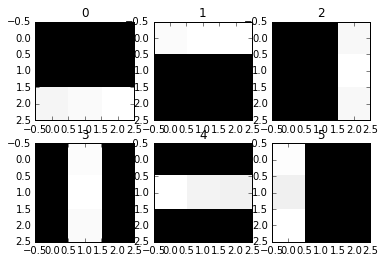

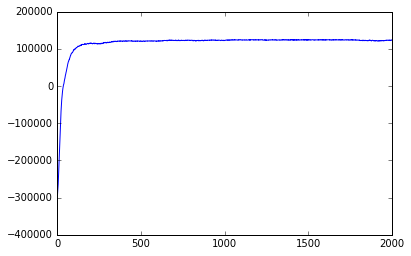

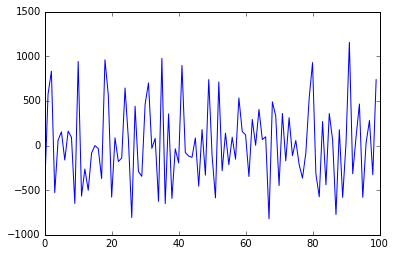

In [4]:
plot_images(plt, results, (rows, rows), (2, rows))
plt.figure()
plt.plot(slda.loglikelihoods)
plt.figure()
plt.plot(np.diff(slda.loglikelihoods)[-100:])

In [42]:
topic = topics[0]

In [43]:
def normalize(lst):
    s = sum(lst)
    return([l/s for l in lst])

min: 0.00517462040329 idx: 25471
max: 15.0194731496 idx: 456050


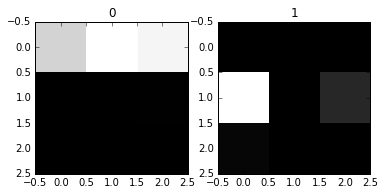

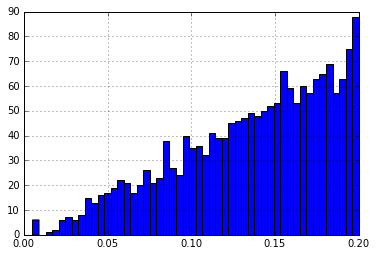

In [57]:
# Generate Dirichlet distributions and find the KL divergence
# with the true topic.
size = 1000000
dirichlets = []
KLs = []
for i in range(size):
    dirichlet = normalize(np.random.dirichlet(np.repeat(0.2, V)) + 1e-7)
    KLs.append(KL_divergence(topic, dirichlet))
    dirichlets.append(dirichlet)
dirichlets = np.array(dirichlets)

print('min:', min(KLs), 'idx:', np.argmin(KLs))
print('max:', max(KLs), 'idx:', np.argmax(KLs))
plt.figure()
plot_images(plt, [dirichlets[np.argmin(KLs)], dirichlets[np.argmax(KLs)]], (rows, rows), (1, 2))
plt.figure()
s = pd.Series(KLs)
s[s<0.2].hist(bins=50)

min: 5.18933020771e-06 idx: 90027
max: 9.64630822163 idx: 804638


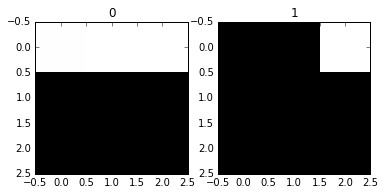

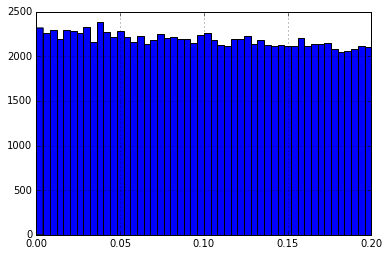

In [58]:
# Generate Dirichlet distributions where the topic has a non-zero
# probability and find the KL divergence with the true topic.
size = 1000000
dirichlets = []
KLs = []
for i in range(size):
    dirichlet = normalize(np.random.dirichlet(topic) + 1e-7)
    KLs.append(KL_divergence(topic, dirichlet))
    dirichlets.append(dirichlet)
dirichlets = np.array(dirichlets)

print('min:', min(KLs), 'idx:', np.argmin(KLs))
print('max:', max(KLs), 'idx:', np.argmax(KLs))
plt.figure()
plot_images(plt, [dirichlets[np.argmin(KLs)], dirichlets[np.argmax(KLs)]], (rows, rows), (1, 2))
plt.figure()
s = pd.Series(KLs)
s[s<0.2].hist(bins=50)

min: 5.99999640023e-07 idx: 0
max: 0.724789128027 idx: 995567


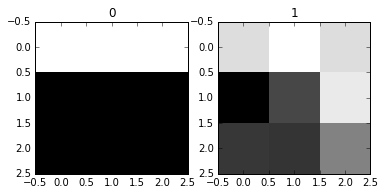

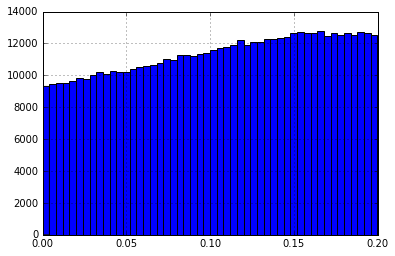

In [59]:
# Add more and more noise to a topic and find the KL divergence with
# the true topic.
size = 1000000
noise_topic = []
KLs = []
for i in range(0, size):
    r = np.abs(np.random.normal(0, 0.1, V)*(i/size)) + 1e-07
    t = normalize(topic + r)
    noise_topic.append(t)
    KLs.append(KL_divergence(topic, t))
noise_topic = np.array(noise_topic)

print('min:', min(KLs), 'idx:', np.argmin(KLs))
print('max:', max(KLs), 'idx:', np.argmax(KLs))
plt.figure()
plot_images(plt, [noise_topic[np.argmin(KLs)], noise_topic[np.argmax(KLs)]], (rows, rows), (1, 2))
plt.figure()
s = pd.Series(KLs)
s[s<0.2].hist(bins=50)

min: 4.85313449661e-07 idx: 896837
max: 0.0673032571001 idx: 916183


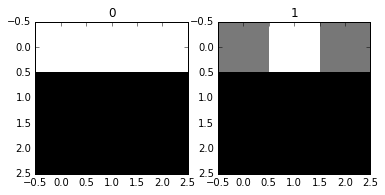

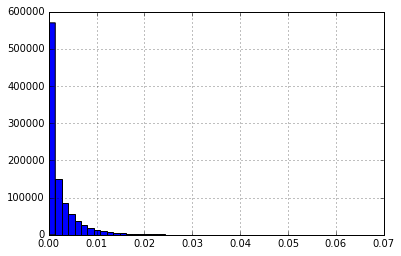

In [60]:
# Add more and more noise to a topic but only where the topic is non-zero
# probability and find the KL divergence with the topic.
size = 1000000
noise_topic = []
KLs = []
for i in range(0, size):
    r = np.abs(np.random.normal(0, 0.1, rows)*(i/size)) + 1e-07
    r = np.pad(r, (0, V-rows), 'constant', constant_values=(0,1e-07))
    t = normalize(topic + r)
    noise_topic.append(t)
    KLs.append(KL_divergence(topic, t))
noise_topic = np.array(noise_topic)

print('min:', min(KLs), 'idx:', np.argmin(KLs))
print('max:', max(KLs), 'idx:', np.argmax(KLs))
plt.figure()
plot_images(plt, [noise_topic[np.argmin(KLs)], noise_topic[np.argmax(KLs)]], (rows, rows), (1, 2))
plt.figure()
s = pd.Series(KLs)
s[s<0.2].hist(bins=50)